# Introduction

This notebook is a companion to `1.0-flowers-in-fastai.ipynb` meant to introduce TensorFlow and Keras to those who already know fastai.

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, 
# as that makes some difference for the code below.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [2]:
# Set to True if you're using Paperspace Gradient:
gradient=False

In [3]:
if colab:
    DATADIR = Path('./gdrive/MyDrive/ColabData')
elif gradient:
    DATADIR = Path('/storage')

else:
    from fastcore.all import *
    NB_DIR = Path.cwd()
    DATADIR = Path('/home/alex/data/dat255')  # Set this to where you want to store downloaded data
    
DATADIR.mkdir(exist_ok=True)

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pickle, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
with open(DATADIR/'path.pkl', 'rb') as f:
    path = pickle.load(f)

# Dataset and dataloaders

We load our flowers using `image_dataset_from_directory`, similarly to what we did using a DataBlock in fastai.

In [4]:
image_size=(224,224)

In [5]:
flowers_train = keras.preprocessing.image_dataset_from_directory(path, 
                                                                    batch_size=64, 
                                                                    image_size=image_size,
                                                                    validation_split=0.2,
                                                                    seed = 42,
                                                                    subset="training")

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-03-21 15:32:04.223102: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 15:32:05.253620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30510 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0


In [6]:
flowers_val = keras.preprocessing.image_dataset_from_directory(path, 
                                                                batch_size=64, 
                                                                image_size=image_size,
                                                                validation_split=0.2,
                                                                seed = 42,
                                                                subset="validation")

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
flowers_val.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Here's a few elements from the first batch:

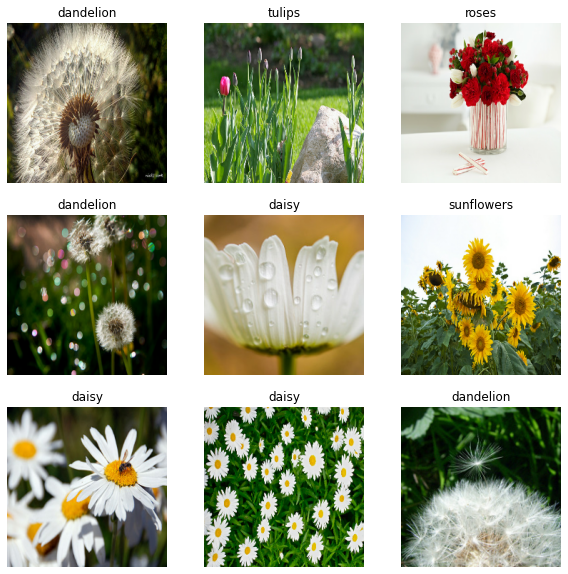

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in flowers_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flowers_train.class_names[int(labels[i])])
        plt.axis("off")


# Train a model

In fastai we used a `cnn_learner` with a pretrained ResNet model as the base model. Let's do it in a similar way with Keras. 

## Data augmentation

We'll need some data augmentation. In Keras, we can add data augmentation by adding layers to the model. 

Here are some examples of data augmentation layers:

In [9]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Resizing(224, 224),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.1),
        keras.layers.RandomContrast(factor=0.01)
    ]
)


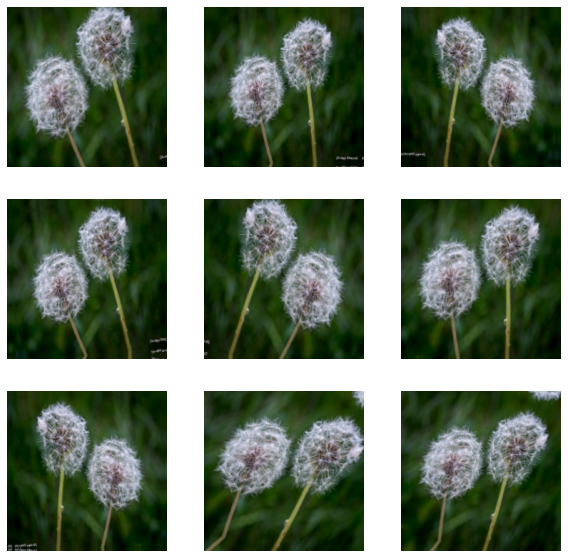

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in flowers_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Instantiate a base model and load pre-trained weights

We cut off the top part of the model (we'll insert our own head later):

In [11]:
image_size + (3,)

(224, 224, 3)

In [12]:
resnet_model = keras.applications.resnet.ResNet50(weights="imagenet",
                                                   input_shape=image_size + (3,), 
                                                   include_top=False)

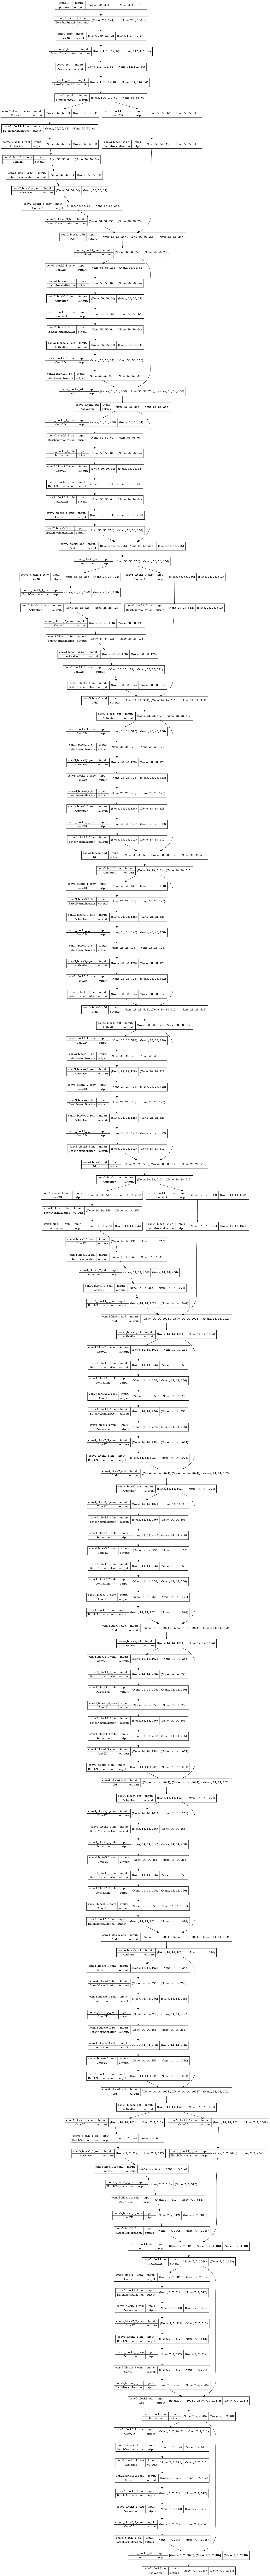

In [13]:
keras.utils.plot_model(resnet_model, show_shapes=True)

## Preprocessing

As the model is pre-trained on a dataset with specific properties (ImageNet) we need to preprocess our data to make it resemble the original data set. We'll do that by inserting a preprocessing layer at the beginning of the model. 

### Extra: check the effect of preprocessing

In [14]:
inputs = keras.Input(shape=image_size + (3,))
outputs = keras.applications.resnet.preprocess_input(inputs)
preprocess_m = keras.Model(inputs, outputs)

In [15]:
preprocess_m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Here's a batch of images:

In [16]:
batch = next(iter(flowers_train.take(1)))[0]

In [17]:
batch.shape

TensorShape([64, 224, 224, 3])

In [18]:
np.mean(batch)

98.40974

Here's the batch after being fed through these preprocessing layers:

In [19]:
batch_pred = preprocess_m.predict(batch)
batch_pred.shape

(64, 224, 224, 3)

In [20]:
batch_pred.mean()

-16.389551

## Add a new head to the model

In [21]:
# Inputs are images (tensors) of a particular size
inputs = keras.Input(image_size + (3,))

# Data augmentation
x = keras.layers.Resizing(224, 224)(inputs)
x = keras.layers.RandomFlip("horizontal")(x)
x = keras.layers.RandomRotation(0.1)(x)
x = keras.layers.RandomZoom(0.1)(x)
x = keras.layers.RandomContrast(factor=0.01)(x)               

# We preprocess the tensors to be compatible with the pretrained base model:
x = keras.applications.resnet.preprocess_input(x)

# Base model:
x = resnet_model(x, training=False)

# Custom head:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.Dropout(rate=0.5)(x)

# Outputs
outputs = keras.layers.Dense(5, activation="softmax")(x)

In [22]:
model = keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                   

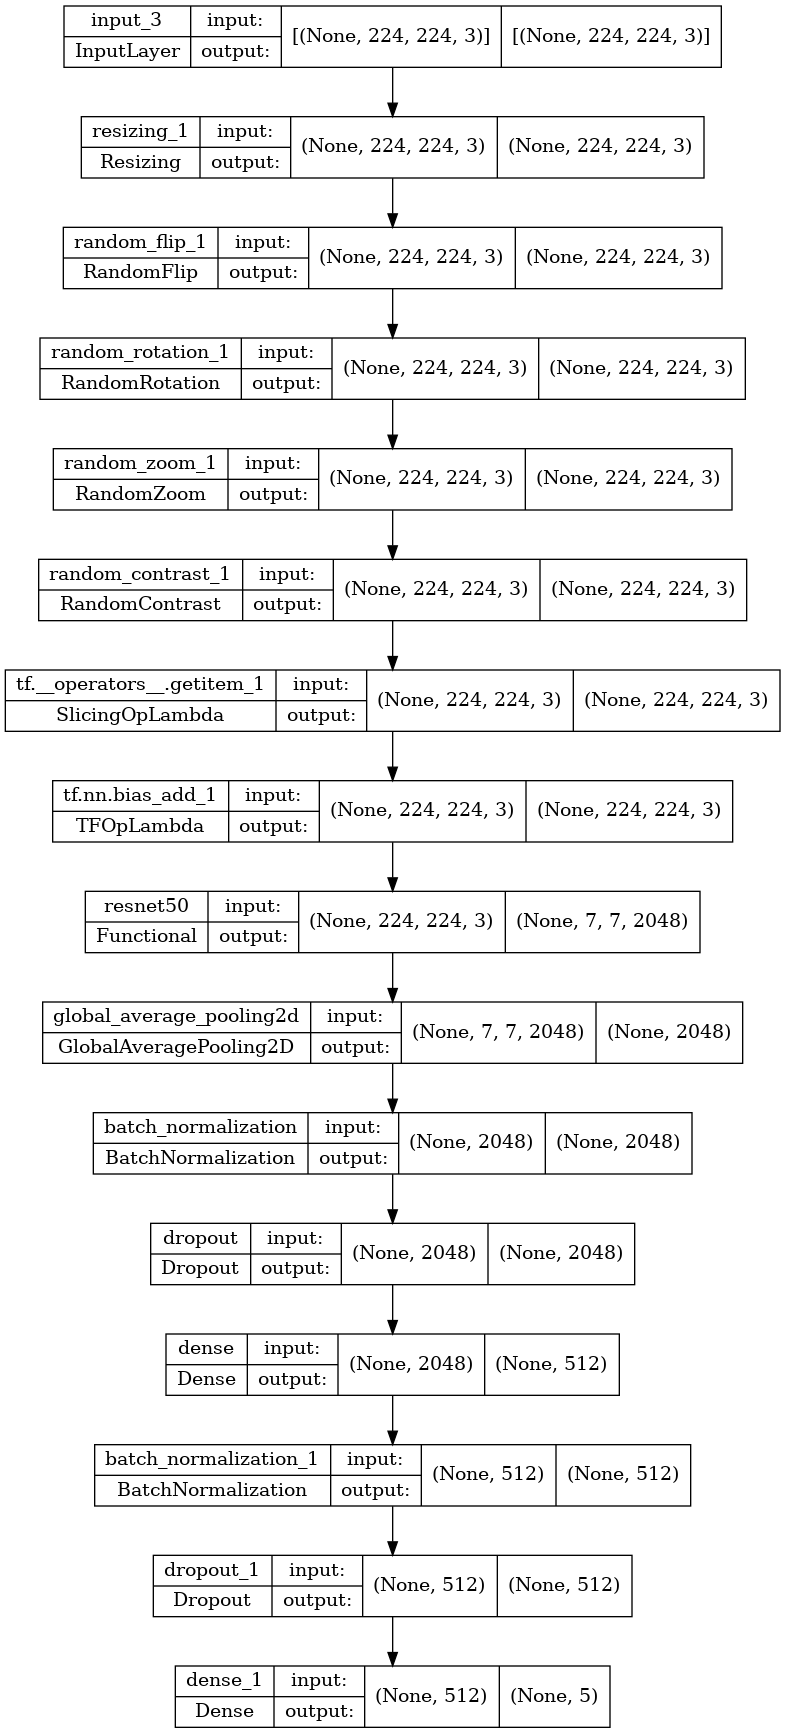

In [24]:
keras.utils.plot_model(model, show_shapes=True)

## Train the head of the model

In [25]:
train_ds = flowers_train.prefetch(buffer_size=64)
val_ds = flowers_val.prefetch(buffer_size=64)

In [26]:
resnet_model.trainable=False

In [27]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics = "accuracy")

Note: if we wanted to stick closer to fastai ideas, we could use cyclical learning rates from [TensorFlow addons](https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate), and also a [learning rate finder](https://pyimagesearch.com/2019/08/05/keras-learning-rate-finder/).

In [28]:
#from tensorflow_addons.optimizers import CyclicalLearningRate

In [29]:
model.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3


2022-03-21 15:32:24.257961: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-21 15:32:25.563587: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-21 15:32:25.564004: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-21 15:32:25.564030: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-21 15:32:25.564628: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-21 15:32:25.564728: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


46/46 [==============================] - 17s 144ms/step - loss: 0.7761 - accuracy: 0.7762 - val_loss: 0.5526 - val_accuracy: 0.8501
Epoch 2/3
46/46 [==============================] - 5s 103ms/step - loss: 0.3599 - accuracy: 0.8893 - val_loss: 0.4251 - val_accuracy: 0.8842
Epoch 3/3
46/46 [==============================] - 5s 103ms/step - loss: 0.2882 - accuracy: 0.8999 - val_loss: 0.3656 - val_accuracy: 0.8965


## Unfreeze and fine-tune the model

In [30]:
resnet_model.trainable=True

In [31]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
             metrics = "accuracy")

In [32]:
model.fit(train_ds, epochs=2, validation_data=val_ds)

Epoch 1/2
46/46 [==============================] - 23s 283ms/step - loss: 0.2320 - accuracy: 0.9213 - val_loss: 0.3558 - val_accuracy: 0.9114
Epoch 2/2
46/46 [==============================] - 12s 247ms/step - loss: 0.1383 - accuracy: 0.9479 - val_loss: 0.3342 - val_accuracy: 0.9183


# Evaluate the model

In [33]:
loss, acc = model.evaluate(flowers_val)
print("Accuracy: ", acc)

12/12 [==============================] - 1s 69ms/step - loss: 0.3342 - accuracy: 0.9183
Accuracy:  0.9182561039924622
